

## The Optimizer



In [110]:

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from collections import defaultdict
from functools import reduce
from itertools import product
import numpy as np
from qiskit import Aer, QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from scipy.optimize import minimize_scalar, minimize
from numpy import pi
import random

PAULIS = {
    "I": np.eye(2, dtype=complex),
    "X": np.array([[0, 1], [1, 0]], dtype=complex),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),
    "Z": np.array([[1, 0], [0, -1]], dtype=complex),
}


def pauli_decomposition(H):
    n = int(np.log2(len(H)))
    dims = 2 ** n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat=n)]
    components = defaultdict(int)

    for i, val in enumerate(product(PAULIS.values(), repeat=n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1)) / dims
        coeff = np.real_if_close(coeff).item()
        
        if not np.allclose(coeff, 0):
            components[basis_key[i]] = coeff

    return components


def matrix_decomposition_circuits(H,add_ansatz):
    n = int(np.log2(len(H)))
    dims = 2 ** n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    components = pauli_decomposition(H)
    
    circuits = {}
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc, qr)

        # don't do anything if all Paulis are I
        if all(x[1] == "I" for x in paulis):
            # we use this empty circuit that we will measure as "0" (eigenvalue 1) in all cases
            circuits[paulistring] = (qc, weight)
            qc.measure(qr[-1], cr[0])
            continue
        
        # do the single qubit transformations
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
                
        # add the inter-qubit gates
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
            
        # measure the highest qubit
        qc.measure(qr[-1], cr[0])
        
        circuits[paulistring] = (qc, weight)
        
    return circuits

def ansatz(qc, qr, thetas, rounds=3):
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r*len(qr)*2 +i*2
            
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset+1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i-1], qr[i])
            
    return qc


def run_circuit(circuit, backend, shots=1000):
    result = execute(circuit, backend, shots=shots).result()
    counts = result.get_counts()
    return (
        (counts["0"] if "0" in counts.keys() else 0)
        - (counts["1"] if "1" in counts.keys() else 0)
    )/shots
    
    
def expectation(H, rounds, thetas):
    backend = Aer.get_backend('qasm_simulator')
    circuits = matrix_decomposition_circuits(
        H,
        lambda qc, qr: ansatz(qc, qr, thetas, rounds)
    )
    #print (circuits)
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))

In [111]:
class SPSA:
    
    def __init__(self, a, c, A, alpha, gamma, H, loss_function):
        # Initialize gain parameters and decay factors
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function

        # counters
        self.t = 0
        

    def step(self, current_estimate):
        # get the current values for gain sequences
        a_t = self.a / (self.t + 1 + self.A)**self.alpha
        c_t = self.c / (self.t + 1)**self.gamma

        # get the random perturbation vector from bernoulli distribution
        delta = np.random.randint(0,2, np.array(current_estimate).shape) * 2 - 1
        
        # measure the loss function at perturbations
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
        # compute the estimate of the gradient
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
        
        # update the estimate of the parameter
        current_estimate = current_estimate - a_t * g_t

        # increment the counter
        self.t += 1

        return current_estimate
#CAPTION The SPSA optimizer

In [112]:
def vqe(H, rounds, max_iter, thetas=None, save_steps=None):
    
    cnt_qubits = int(np.log2(len(H)))
    if thetas is None:
        thetas = list(map(
                lambda x: random.random(),
                [0] * ((1+rounds)*cnt_qubits*2)
            ))
    
    # create the optimizer class
    optimizer = SPSA(
        a=0.9,
        c=1.0,
        A=max_iter/10,
        alpha=0.6,
        gamma=0.1,
        H=H,
        loss_function=lambda t_thetas: expectation(H, rounds, t_thetas))

    # the main loop
    for i in range(max_iter):
        thetas = optimizer.step(thetas)
        
        if save_steps is not None and i % save_steps == 0:
            yield (i, thetas, expectation(H, rounds, thetas))

    return (thetas, expectation(H, rounds, thetas))
#CAPTION The Variational Quantum Eigensolver

In [113]:
H = np.array(
    [[3, 1],
     [1, 2]],
    dtype=complex
)

result = None
step_size = 3
for step in vqe(H, rounds=3, max_iter=60, save_steps=step_size):
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step=step[0], ev=step[2]))
    result = step
    
print('The solution is: [\n'
    +"".join(["\t"+str(round(t, 3))
    +",\n" if i%3 == 2 else "\t"+str(round(t, 3))
    +",\t" for i, t in enumerate(result[1])])+"]")
print('The lowest expectation value is: {ev: .3f}'.format(ev=result[2]))
#CAPTION Solving an exemplary problem

Step 0. Current expectation value:  3.140
Step 3. Current expectation value: -1.568
Step 6. Current expectation value: -1.862
Step 9. Current expectation value: -1.931
Step 12. Current expectation value: -2.747
Step 15. Current expectation value: -2.803
Step 18. Current expectation value: -2.731
Step 21. Current expectation value: -3.158
Step 24. Current expectation value: -2.755
Step 27. Current expectation value: -2.937
Step 30. Current expectation value: -3.091
Step 33. Current expectation value: -2.917
Step 36. Current expectation value: -3.053
Step 39. Current expectation value: -2.945
Step 42. Current expectation value: -3.012
Step 45. Current expectation value: -3.190
Step 48. Current expectation value: -3.058
Step 51. Current expectation value: -3.046
Step 54. Current expectation value: -3.138
Step 57. Current expectation value: -3.231
The solution is: [
	0.997,		-0.419,		1.379,
	0.847,		0.815,		1.177,
	0.172,		0.305,	]
The lowest expectation value is: -3.231


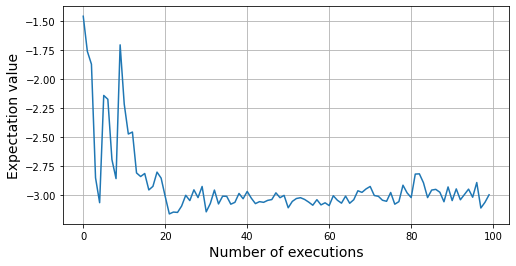

In [114]:
import matplotlib.pyplot as plt

steps = []
evs = []
for step in vqe(H, rounds=3, max_iter=100, save_steps=1):
    steps = steps + [step[2]]
    evs = evs + [step[0]]


plt.figure(figsize=(8, 4))
plt.plot(evs, steps)

plt.xlabel("Number of executions", fontsize=14)
plt.ylabel("Expectation value", fontsize=14)
plt.grid()

plt.show()
#CAPTION Plotting the optimization

In [101]:
import scipy

# Calculate eigenvalues and eigenvectors of H
eigenvalues, eigenvectors = scipy.linalg.eig(H)
print("Eigenvalues:", eigenvalues)

Eigenvalues: [3.61803399+0.j 1.38196601+0.j]
